In [129]:
from keras.layers.rnn import GRU
import numpy as np
import pandas as pd
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import Embedding 
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
files.upload()

In [130]:
# считывание жанных из файла
data = pd.read_csv('/content/CBOT.$DJUSBK_120711_160711.csv')

data["<DATE>"] = data["<DATE>"].astype(str)
for i in range(0, len(data["<DATE>"])):
  data["<DATE>"][i] = datetime(int(data["<DATE>"][i][0:4]), int(data["<DATE>"][i][4:6]), int(data["<DATE>"][i][6:8]))
  data["<DATE>"][i] = datetime.timestamp(data["<DATE>"][i])

data = data[['<DATE>','<TIME>','<OPEN>','<HIGH>','<LOW>','<VOL>','<CLOSE>']]
data = data.apply(pd.to_numeric) # преобразуем в числовой формат
X = data.iloc[:,:data.shape[1]-1]
Y = data.iloc[:, data.shape[1]-1]
X_train, X_test, y_train, y_test = X.iloc[:700], X.iloc[700:], Y.iloc[:700], Y.iloc[700:]

print('Обучающие данные')
pd.concat([X_train,y_train], axis=1)

<ipython-input-130-9c93982ecc8b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["<DATE>"][i] = datetime(int(data["<DATE>"][i][0:4]), int(data["<DATE>"][i][4:6]), int(data["<DATE>"][i][6:8]))
<ipython-input-130-9c93982ecc8b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["<DATE>"][i] = datetime.timestamp(data["<DATE>"][i])


Обучающие данные


,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<VOL>,<CLOSE>
0,1.341965e+09,0,96.755102,98.193880,96.602041,4,97.82143
1,1.342051e+09,0,97.311224,97.311224,96.239800,4,96.43878
2,1.342138e+09,0,96.510204,100.244900,96.510204,5,100.08674
3,1.342397e+09,0,99.852041,100.443880,99.193880,4,99.63265
4,1.342483e+09,0,99.872449,100.454080,98.673470,6,100.45408
...,...,...,...,...,...,...,...
695,1.429229e+09,0,166.438750,166.438750,163.561200,4679,164.07140
696,1.429488e+09,0,164.107120,165.469360,164.107120,4675,164.84181
697,1.429574e+09,0,164.877520,165.821400,163.515280,4692,163.87242
698,1.429661e+09,0,163.887730,165.938750,163.346910,4685,165.34691


In [131]:
print('Тестовые данные')  
pd.concat([X_test,y_test], axis=1)

Тестовые данные


,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<VOL>,<CLOSE>
700,1.429834e+09,0,165.117320,165.219360,164.173440,4680,164.403030
701,1.430093e+09,0,164.408140,165.903030,163.989770,4657,164.005080
702,1.430179e+09,0,164.015280,165.479570,163.295890,4664,165.326500
703,1.430266e+09,0,165.244870,167.688750,164.928550,4676,166.913240
704,1.430352e+09,0,166.862220,167.387730,165.204060,4689,166.020380
...,...,...,...,...,...,...,...
997,1.467763e+09,0,142.867324,144.433650,140.979569,4683,144.300997
998,1.467850e+09,0,144.311201,146.709160,144.311201,4697,145.321405
999,1.467936e+09,0,145.693854,148.846915,145.693854,4686,147.928548
1000,1.468195e+09,0,147.989772,150.127527,147.989772,4685,149.025486


In [132]:
import matplotlib.pyplot as plt

def create_plot(title, xlabel, ylabel, dataxg1, datayg1, label1, flag, dataxg2, datayg2, label2):
  
  plt.figure(figsize=(15, 6))
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.plot(dataxg1, datayg1, label=label1)
  if flag==1: 
    plt.plot(dataxg2, datayg2, label=label2)
  plt.legend()
  plt.show()

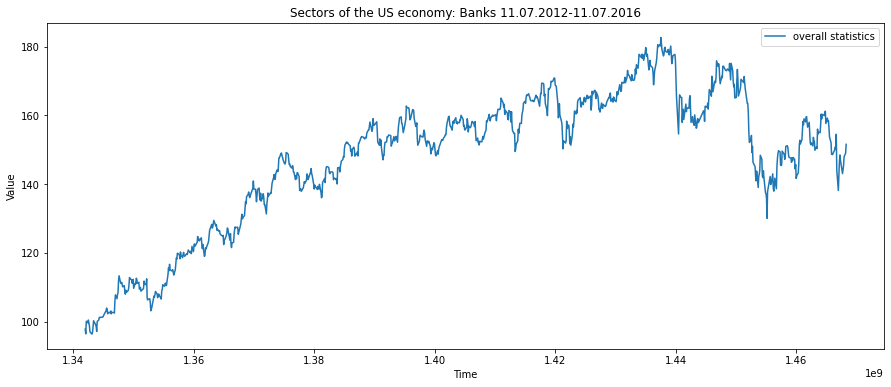

In [133]:
create_plot('Sectors of the US economy: Banks 11.07.2012-11.07.2016', "Time", "Value", data["<DATE>"], data["<CLOSE>"],'overall statistics', 0, None,None, None)

In [134]:
def build_model():
  model = Sequential()
  # изменяет формат данных (делает 3-х мерный массив, чтобы его принял слой GRU)
  # исп. чтобы убедиться, что размерность входных данных совпадает с тем, которые принимает GRU
  model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]))
  model.add(GRU(256))
  model.add(Dense(256, activation = "relu"))
  model.add(Dense(256, activation = "relu"))
  #исп. линейную ф-ию активации для выходного слоя
  model.add(Dense(1, activation='linear'))
  #производим компиляцию нашей модели
  model.compile(optimizer="adam", loss='mae',  metrics=['mae']) 

  return model



In [135]:
#построение и обучение модели
model = build_model()
history = model.fit(X_train, y_train, epochs=25, batch_size=25,   validation_split=0.05,  verbose=1) #визуализация хода обучения

Epoch 1/25
27/27 [==============================] - 3s 40ms/step - loss: 89.8715 - mae: 89.8715 - val_loss: 3.7495 - val_mae: 3.7495
Epoch 2/25
27/27 [==============================] - 1s 20ms/step - loss: 19.3802 - mae: 19.3802 - val_loss: 20.5389 - val_mae: 20.5389
Epoch 3/25
27/27 [==============================] - 1s 20ms/step - loss: 17.3577 - mae: 17.3577 - val_loss: 15.1296 - val_mae: 15.1296
Epoch 4/25
27/27 [==============================] - 1s 20ms/step - loss: 14.5283 - mae: 14.5283 - val_loss: 4.8119 - val_mae: 4.8119
Epoch 5/25
27/27 [==============================] - 1s 21ms/step - loss: 6.7574 - mae: 6.7574 - val_loss: 5.9678 - val_mae: 5.9678
Epoch 6/25
27/27 [==============================] - 1s 20ms/step - loss: 3.1433 - mae: 3.1433 - val_loss: 1.2018 - val_mae: 1.2018
Epoch 7/25
27/27 [==============================] - 1s 20ms/step - loss: 4.8892 - mae: 4.8892 - val_loss: 1.2152 - val_mae: 1.2152
Epoch 8/25
27/27 [==============================] - 1s 20ms/step - loss

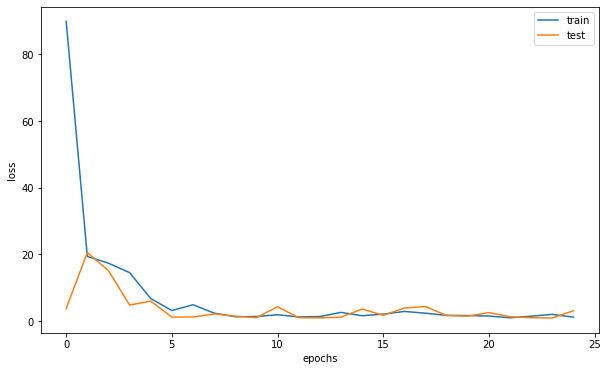

In [136]:

plt.figure(figsize=(10, 6))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

22/22 [==============================] - 1s 7ms/step


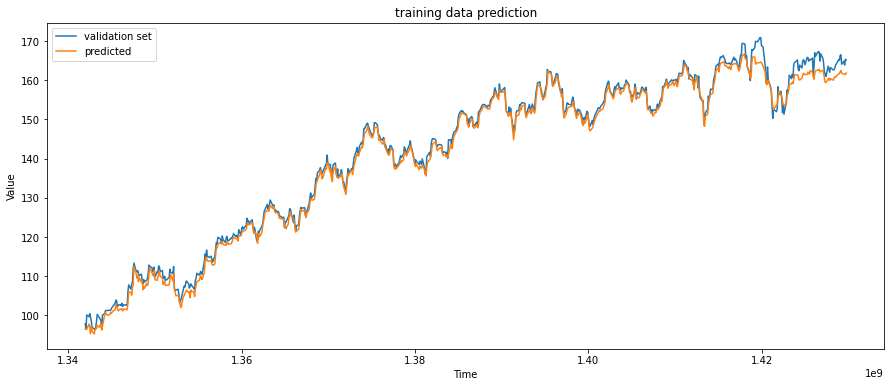

In [137]:
# предсказание тренеровочных данных
predict = model.predict(X_train)

create_plot('training data prediction', "Time", "Value", X_train["<DATE>"], y_train,'validation set', 1, X_train["<DATE>"],predict, "predicted")

In [138]:
# Оценка качества
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: ',  train_mse, 'Test: ',test_mse)

Train:  [1.2482523918151855, 1.2482523918151855] Test:  [4.684031009674072, 4.684031009674072]


10/10 [==============================] - 0s 7ms/step


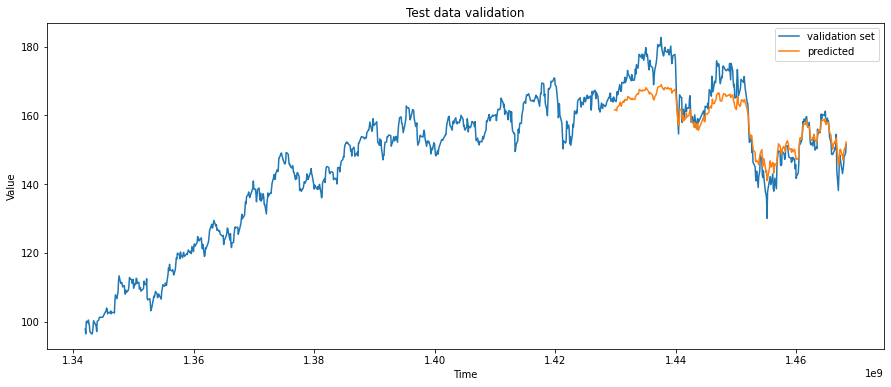

In [139]:
# реальные данные
predict = model.predict(X_test)

# Plot
create_plot('Test data validation', "Time", "Value", X["<DATE>"], Y,'validation set', 1,X_test["<DATE>"],predict, "predicted")

In [140]:
pred = model.predict(X_test).flatten() 
for i in range(y_test.shape[0]):
   print("дата:", datetime.fromtimestamp(X_test.iloc[i,0]), ", вычисленное значение НС: ", round(pred[i],3), ", верный результат: ", 
         round(y_test.iloc[i],3), ", разница: ", round(y_test.iloc[i] - pred[i],3))

10/10 [==============================] - 0s 7ms/step
дата: 2015-04-24 00:00:00 , вычисленное значение НС:  161.611 , верный результат:  164.403 , разница:  2.792
дата: 2015-04-27 00:00:00 , вычисленное значение НС:  161.659 , верный результат:  164.005 , разница:  2.346
дата: 2015-04-28 00:00:00 , вычисленное значение НС:  161.344 , верный результат:  165.326 , разница:  3.983
дата: 2015-04-29 00:00:00 , вычисленное значение НС:  162.352 , верный результат:  166.913 , разница:  4.561
дата: 2015-04-30 00:00:00 , вычисленное значение НС:  162.483 , верный результат:  166.02 , разница:  3.537
дата: 2015-05-01 00:00:00 , вычисленное значение НС:  162.588 , верный результат:  166.628 , разница:  4.039
дата: 2015-05-04 00:00:00 , вычисленное значение НС:  163.182 , верный результат:  168.954 , разница:  5.772
дата: 2015-05-05 00:00:00 , вычисленное значение НС:  163.848 , верный результат:  168.051 , разница:  4.203
дата: 2015-05-06 00:00:00 , вычисленное значение НС:  162.991 , верный резул

In [ ]:
#сохраняем НС в файл
model.save("NS.h5")
files.download("NS.h5")

In [ ]:
#ипользование уже обученной НС
from keras.models import load_model
files.upload()
model = load_model("NS.h5")